In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from pmdarima.arima import auto_arima
import emd
from matplotlib import rcParams

In [2]:
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
target_column = 'T (degC)'
target_index = 'datetime'
load = df[target_column]
time = df[target_index]
x_label = 'Time'
y_label = 'Temperature (°C)'

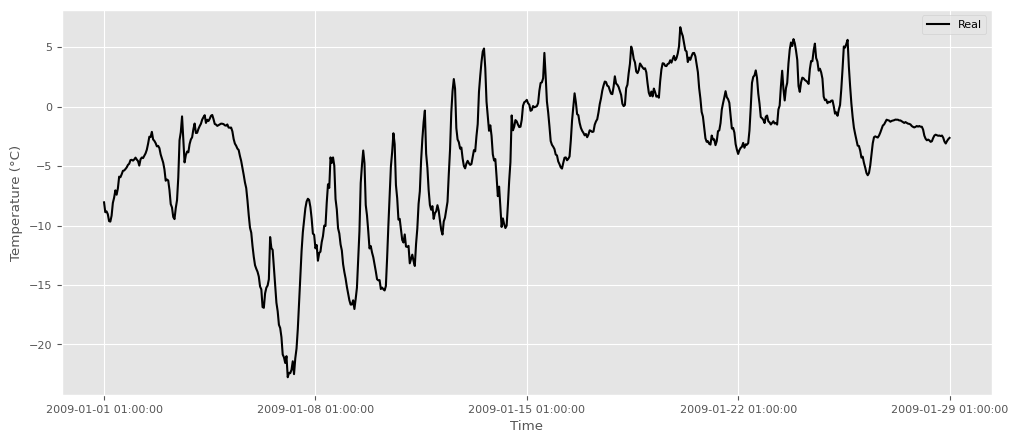

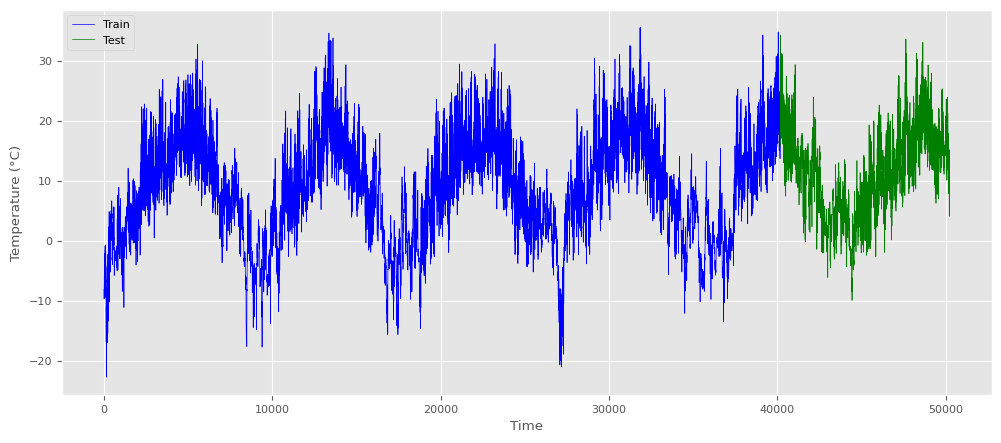

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


In [4]:
plt.plot(time[:673], load[:673], color='k', label='Real')
plt.xticks(np.arange(0, 673, step=168))
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]
plt.plot(train, label='Train', color='b', linewidth=0.5)
plt.plot(test, label='Test', color='g', linewidth=0.5)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
for i in range(1, 4):
    df_train["lag{}".format(i)] = df_train[target_column].shift(i)
    df_test["lag{}".format(i)] = df_test[target_column].shift(i)

df_train = df_train.bfill().drop(columns=[target_column])
df_test = df_test.bfill().drop(columns=[target_column])
display(df_train, df_test)

<Axes: xlabel='Time (samples)'>

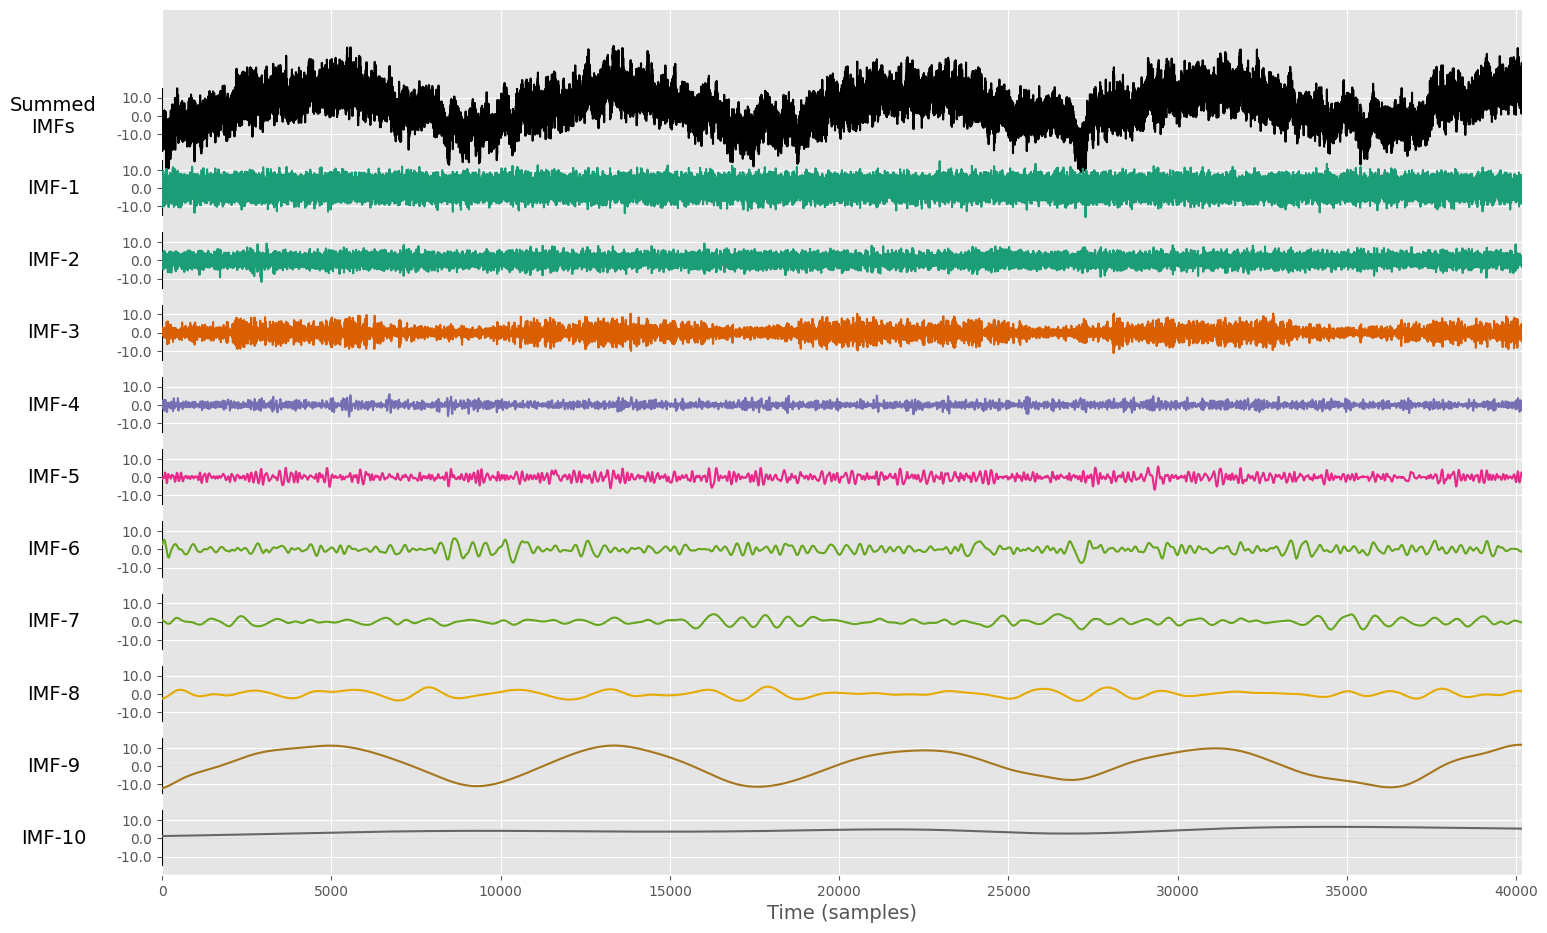

In [5]:
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [6]:
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,4.991523,-2.385219,-1.443137,-1.854095,-0.754579,2.616044,0.941050,-2.487539,-12.219072,1.277809
1,-6.625379,0.359203,-0.680746,-1.786883,-0.744009,2.680523,0.927252,-2.485527,-12.213255,1.278118
2,9.139479,2.848473,0.271678,-1.672250,-0.727590,2.745658,0.913448,-2.483431,-12.207414,1.278428
3,-10.458133,2.975266,1.256419,-1.516080,-0.705958,2.811377,0.899638,-2.481253,-12.201548,1.278737
4,1.980586,1.299736,2.118059,-1.324260,-0.679746,2.877608,0.885822,-2.478992,-12.195658,1.279047
...,...,...,...,...,...,...,...,...,...,...
40174,4.855584,-0.609780,-3.799204,2.200091,2.547605,-1.053283,-0.399957,1.596166,11.683784,5.347489
40175,0.007162,-1.136818,-4.291056,2.234520,2.527773,-1.040436,-0.398884,1.593697,11.682818,5.347306
40176,-0.454692,-2.591007,-4.603567,2.252959,2.506762,-1.027157,-0.397661,1.591202,11.681837,5.347124
40177,-1.287491,-3.565085,-4.691993,2.257058,2.484770,-1.013454,-0.396291,1.588681,11.680841,5.346941


In [7]:
from statsmodels.tsa.arima.model import ARIMA

imf1_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_1'], order=(2, 0, 4)).fit()
imf1_eemd_arima_fc = imf1_eemd_arima.forecast(steps=len(test))

imf2_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_2'], order=(5, 0, 4)).fit()
imf2_eemd_arima_fc = imf2_eemd_arima.forecast(steps=len(test))

imf3_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_3'], order=(5, 0, 5)).fit()
imf3_eemd_arima_fc = imf3_eemd_arima.forecast(steps=len(test))

imf4_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_4'], order=(4, 0, 5)).fit()
imf4_eemd_arima_fc = imf4_eemd_arima.forecast(steps=len(test))

imf5_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_5'], order=(4, 0, 4)).fit()
imf5_eemd_arima_fc = imf5_eemd_arima.forecast(steps=len(test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
imf6_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_6'], order=(5, 2, 0)).fit()
imf6_eemd_arima_fc = imf6_eemd_arima.forecast(steps=len(test))

imf7_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_7'], order=(2, 1, 0)).fit()
imf7_eemd_arima_fc = imf7_eemd_arima.forecast(steps=len(test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
imf8_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_8'], order=(2, 1, 0)).fit()
imf8_eemd_arima_fc = imf8_eemd_arima.forecast(steps=len(test))

imf9_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_9'], order=(0, 2, 0)).fit()
imf9_eemd_arima_fc = imf9_eemd_arima.forecast(steps=len(test))

imf10_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_10'], order=(0, 2, 0)).fit()
imf10_eemd_arima_fc = imf10_eemd_arima.forecast(steps=len(test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

In [11]:
imf_eemd_fc = np.sum([imf1_eemd_arima_fc, imf2_eemd_arima_fc, imf3_eemd_arima_fc,
                imf4_eemd_arima_fc, imf5_eemd_arima_fc,imf6_eemd_arima_fc,
                imf7_eemd_arima_fc,imf8_eemd_arima_fc,imf9_eemd_arima_fc, imf10_eemd_arima_fc], axis = 0)

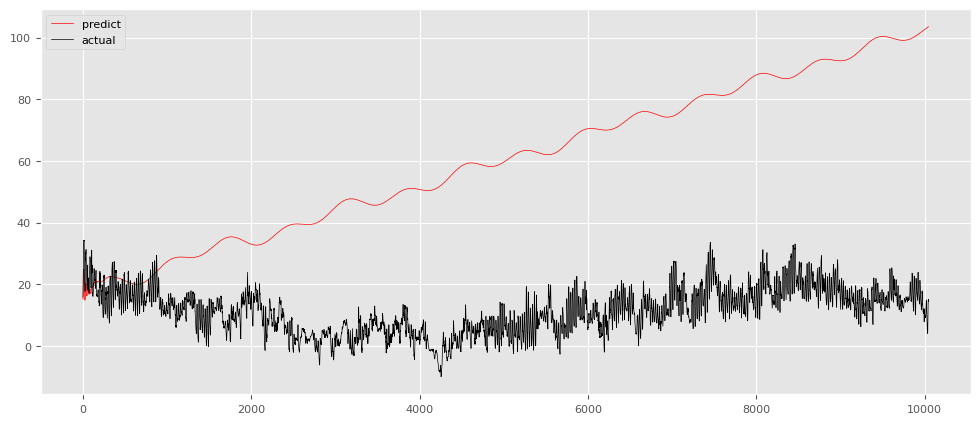

MAE = 49.19696206706424 
MAPE = 50295319143399.25


In [12]:
plt.plot(imf_eemd_fc,label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
#plt.savefig('EEMDSVR')
plt.show()

# RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))